# Baichuan-13B 保姆级微调范例

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

干货预警：这可能是你能够找到的最容易懂的，最完整的，适用于各种NLP任务的Baichuan-13B-Chat的finetune教程~

Baichuan-13B是百川智能于2023年7月11日发布的开源中英双语LLM，各项指标经评测在开源LLM中同尺寸模型中位居前列。

Baichuan-13B包括Baichuan-13B-Base和Baichuan-13B-chat两个不同模型。前者仅仅是预训练模型，后者在前者基础上增加了SFT,RLHF等偏好对齐过程。

本范例微调的模型是Baichuan-13B-Chat，我们使用非常简单的，外卖评论数据集来实施微调，对一段外卖评论区分是好评还是差评。

可以发现，经过微调后的模型，相比直接 3-shot-prompt 可以取得明显更好的效果(0.89->0.90)。

虽然Baichuan-13B-Chat是一个百亿级的LLM，但由于我们使用非常节约显存的QLoRA微调算法，具备32G左右显存的GPU即可实施本过程。

值得注意的是，尽管我们以文本分类任务为例，实际上，任何NLP任务，例如，命名实体识别，翻译，聊天对话等等，都可以通过加上合适的上下文，转换成一个对话问题，并针对我们的使用场景，设计出合适的数据集来微调Baichuan-13B-Chat.


注，本教程是 ChatGLM2-6b保姆级微调范例 的兄弟版本~


In [ ]:
#安装环境

#baichuan-13b-chat
#!pip install 'transformers==4.30.2'
#!pip install  -U transformers_stream_generator


#finetune
#!pip install datasets
#!pip install git+https://github.com/huggingface/accelerate
#!pip install  git+https://github.com/huggingface/peft
#!pip install  git+https://github.com/lyhue1991/torchkeras 
#!pip install 'bitsandbytes==0.39.1' #4bit量化

In [1]:
!du -s -h ../baichuan-13b

25G	../baichuan-13b


## 〇，预训练模型

我们需要从 https://huggingface.co/baichuan-inc/Baichuan-13B-Chat 下载baichuan-13b-chat的模型。

国内可能速度会比较慢，总共有25个G左右，网速不太好的话，大概可能需要两到三个小时。

如果网络不稳定，也可以手动从这个页面一个一个下载全部文件然后放置到 一个文件夹中例如 'baichuan-13b' 以便读取。


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn


#使用QLoRA引入的 NF4量化数据类型以节约显存
model_name_or_path ='../baichuan-13b' #远程 'baichuan-inc/Baichuan-13B-Chat'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


[2023-07-19 20:58:18,589] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from IPython.display import clear_output 
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是哪座?"})
response = model.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)
    
    

乔戈里峰。世界第二高峰———乔戈里峰海拔高度：8610米坐标：35.5°n,76.5°e乔戈里，蒙古语意为“高大雄伟”，它位于喀喇昆仑山脉的中部。


下面我们设计一个3-shot-prompt方法，使用外卖数据集测试一下BaiChuan13b的文本分类能力。

In [ ]:
prefix = """外卖评论文本分类任务:
下面是一些范例:

味道真不错 -> 好评
太辣了，吃不下都  -> 差评

请对下述评论进行分类。返回'好评'或者'差评'。
"""

def get_prompt(text):
    return prefix+text+' -> '


In [ ]:
messages  = [{"role": "user", "content": get_prompt('味道不错，下次再来')}]
response = model.chat(tokenizer, messages)
print(response)


好评


In [11]:
messages = messages+[{"role": "assistant", "content": response}]
print(messages)


[{'role': 'user', 'content': "外卖评论文本分类任务:\n下面是一些范例:\n\n味道真不错 -> 好评\n太辣了，吃不下都  -> 差评\n\n请对下述评论进行分类。返回'好评'或者'差评'。\n味道不错，下次再来 -> "}, {'role': 'assistant', 'content': '好评'}]


In [12]:
def get_message(prompt,response):
    return [{"role": "user", "content": f'{prompt} -> '},
            {"role": "assistant", "content": response}]

In [13]:
messages.extend(get_message('太贵了','差评'))
messages.extend(get_message('非常快，味道好','好评'))
messages.extend(get_message('这么咸，真的是醉了','差评'))

In [14]:
messages 

[{'role': 'user',
  'content': "外卖评论文本分类任务:\n下面是一些范例:\n\n味道真不错 -> 好评\n太辣了，吃不下都  -> 差评\n\n请对下述评论进行分类。返回'好评'或者'差评'。\n味道不错，下次再来 -> "},
 {'role': 'assistant', 'content': '好评'},
 {'role': 'user', 'content': '太贵了 -> '},
 {'role': 'assistant', 'content': '差评'},
 {'role': 'user', 'content': '非常快，味道好 -> '},
 {'role': 'assistant', 'content': '好评'},
 {'role': 'user', 'content': '这么咸，真的是醉了 -> '},
 {'role': 'assistant', 'content': '差评'}]

In [25]:
def predict(text,temperature=0.01):
    model.generation_config.temperature=temperature
    response = model.chat(tokenizer, 
                          messages = messages+[{'role':'user','content':f'{text} -> '}])
    return response


In [26]:
predict('死鬼，咋弄得这么有滋味呢！') #惊喜，居然预测对了

'好评'

我们拿外卖数据集来测试一下未经微调，预训练模型的效果。

In [27]:
import pandas as pd 
import numpy as np 
import datasets 
from tqdm import tqdm 

#数据集分割
# df = pd.read_csv("data/waimai_10k.csv")

# df['tag'] = df['label'].map({0:'差评',1:'好评'})
# df = df.rename({'review':'text'},axis = 1)

# dfgood = df.query('tag=="好评"')
# dfbad = df.query('tag=="差评"').head(len(dfgood)) #采样部分差评，让好评差评平衡
# df = pd.concat([dfgood,dfbad])

# ds_dic = datasets.Dataset.from_pandas(df).train_test_split(
#     test_size = 2000,shuffle=True, seed = 43)
# dftrain = ds_dic['train'].to_pandas()
# dftest = ds_dic['test'].to_pandas()
# dftrain.to_parquet('../data/dftrain.parquet')
# dftest.to_parquet('../data/dftest.parquet')


In [ ]:
#数据集加载
dftrain = pd.read_parquet('../data/dftrain.parquet')[['text','label','tag']]
dftest = pd.read_parquet('../data/dftest.parquet')[['text','label','tag']]
ds_train,ds_val = datasets.Dataset.from_pandas(dftrain).train_test_split(
    test_size=1000,seed=42).values()\

dftrain,dfval = ds_train.to_pandas(), ds_val.to_pandas() 

In [28]:
dftest['pred'] = [predict(text) for text in tqdm(dftest['text'])]

100%|██████████| 2000/2000 [10:28<00:00,  3.18it/s]


In [29]:
dftest.query('tag==pred').shape  

(1785, 4)

In [57]:
print('acc = ',len(dftest.query('tag==pred'))/len(dftest))   

acc =  0.8925


In [31]:
dftest.pivot_table(index='pred',columns = 'tag',
                   values='text',aggfunc='count')


tag,好评,差评
pred,,
好评,853.0,74.0
差评,140.0,932.0
无法判断,1.0,NaN


## 一，准备数据

我们仿照百川模型的 `model._build_chat_input` 方法来进行token编码，同时把需要学习的内容添加label.

### 1，token编码

In [32]:
import torch 

#将messages编码成 token, 同时返回labels, 该函数适用于多轮对话数据
#注意baichuan-13b通过插入tokenizer.user_token_id和tokenizer.assistant_token_id 来区分用户和机器人会话内容

# reference@ model._build_chat_input?
def build_chat_input(messages, model=model,
                     tokenizer=tokenizer, 
                     max_new_tokens: int=0):
    max_new_tokens = max_new_tokens or model.generation_config.max_new_tokens
    max_input_tokens = model.config.model_max_length - max_new_tokens
    max_input_tokens = max(model.config.model_max_length // 2, max_input_tokens)
    
    total_input, round_input, total_label, round_label = [], [], [], []
    
    for i, message in enumerate(messages[::-1]):
        content_tokens = tokenizer.encode(message['content'])
        if message['role'] == 'user':
            round_input = [model.generation_config.user_token_id] + content_tokens + round_input
            round_label = [-100]+[-100 for _ in content_tokens]+ round_label
            
            if total_input and len(total_input) + len(round_input) > max_input_tokens:
                break
            else:
                total_input = round_input + total_input
                total_label = round_label + total_label
                if len(total_input) >= max_input_tokens:
                    break
                else:
                    round_input = []
                    round_label = []
                    
        elif message['role'] == 'assistant':
            round_input = [
                model.generation_config.assistant_token_id
            ] + content_tokens + [
                model.generation_config.eos_token_id
            ] + round_input

            round_label = [
                -100
            ] + content_tokens + [
                model.generation_config.eos_token_id
            ]+ round_label
        else:
            raise ValueError(f"message role not supported yet: {message['role']}")
            
    total_input = total_input[-max_input_tokens:]  # truncate left
    total_label = total_label[-max_input_tokens:]
    
    total_input.append(model.generation_config.assistant_token_id)
    total_label.append(-100)
    
    return total_input,total_label


### 2，做数据集

In [38]:
from torch.utils.data import Dataset,DataLoader 
class MyDataset(Dataset):
    def __init__(self,df,
                 prefix=prefix
                ):
        self.df = df 
        self.prefix=prefix
        
    def __len__(self):
        return len(self.df)
        
    def get_samples(self,index):
        samples = []
        d = dict(self.df.iloc[index])
        samples.append(d)
        return samples
    
    def get_messages(self,index):
        samples = self.get_samples(index)
        messages = []
        for i,d in enumerate(samples):
            if i==0:
                messages.append({'role':'user','content':self.prefix+d['text']+' -> '})
            else:
                messages.append({'role':'user','content':d['text']+' -> '})
            
            messages.append({'role':'assistant','content':d['tag']})
        return messages
        
    def __getitem__(self,index):
        messages = self.get_messages(index)
        input_ids, labels = build_chat_input(messages)
        return {'input_ids':input_ids,'labels':labels}

    def show_sample(self,index):
        samples = self.get_samples(index)
        print(samples)
    
    

In [39]:
ds_train = MyDataset(dftrain)
ds_val = MyDataset(dfval)


In [41]:
ds_train.show_sample(0)

[{'text': '送的慢1个多小时，卷饼特别干，没有老北京鸡肉卷好吃，因为里面没有酱，而且肉不太好，感觉不一定是肘子肉，不会再吃了', 'label': 0, 'tag': '差评'}]


In [42]:
print(ds_train[0]) 

{'input_ids': [195, 31106, 17924, 9929, 31271, 31267, 10732, 5934, 31143, 5, 7810, 31161, 2719, 31751, 31530, 31143, 5, 5, 10685, 31426, 6891, 11531, 31106, 24275, 5, 31605, 32747, 31172, 72, 31604, 18444, 31228, 99, 3817, 31106, 31965, 31784, 5, 5, 31488, 31209, 31214, 32193, 9929, 1696, 10732, 73, 17965, 31155, 24275, 31155, 2818, 31155, 31965, 31784, 31155, 73, 5, 31818, 31135, 32044, 53, 31179, 31206, 4237, 72, 32303, 33063, 3450, 31621, 72, 1449, 31367, 3659, 32180, 31915, 32303, 22823, 72, 1863, 7515, 1449, 33029, 72, 3421, 31915, 13204, 31213, 72, 3994, 31166, 20975, 34318, 31225, 31915, 72, 2753, 31513, 18392, 11531, 31106, 196, 31106, 31965, 31784, 2, 196], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -1

### 3，创建管道

In [45]:
def data_collator(examples: list):
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))
          
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }


In [46]:
import torch 
dl_train = torch.utils.data.DataLoader(ds_train,num_workers=2,batch_size=4,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)

dl_val = torch.utils.data.DataLoader(ds_val,num_workers=2,batch_size=4,
                                    pin_memory=True,shuffle=False,
                                     collate_fn = data_collator)


In [47]:
for batch in dl_train:
    break 

In [50]:
#试跑一个batch
out = model(**batch)

In [51]:
out.loss 

tensor(0.0352, dtype=torch.float16, grad_fn=<ToCopyBackward0>)

In [52]:
len(dl_train)

1250

In [54]:
#采样300个batch作为一个epoch，便于较快验证
dl_train.size = 300

## 二，定义模型

下面我们将使用QLoRA(实际上用的是量化的AdaLoRA）算法来微调Baichuan-13b模型。

In [58]:
from peft import get_peft_config, get_peft_model, TaskType
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [59]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


In [60]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model)


In [61]:
lora_modules = find_all_linear_names(model)
print(lora_modules) 


['down_proj', 'o_proj', 'up_proj', 'W_pack', 'gate_proj']


In [62]:
from peft import AdaLoraConfig
peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=64,
    lora_alpha=16, lora_dropout=0.05,
    target_modules= lora_modules
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()


trainable params: 41,843,040 || all params: 7,002,181,160 || trainable%: 0.5975715144165165


In [63]:
out = peft_model.forward(**batch)

In [64]:
out[0]

tensor(0.0347, grad_fn=<ToCopyBackward0>)

## 三，训练模型

In [65]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net.forward(**batch)[0]

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 

#仅仅保存QLora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 


In [66]:
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=6e-05,is_paged=True)  #'paged_adamw'
keras_model = KerasModel(peft_model,loss_fn =None,
        optimizer=optimizer) 
ckpt_path = 'baichuan13b_waimai'



<<<<<< ⚡️ cuda is used >>>>>>


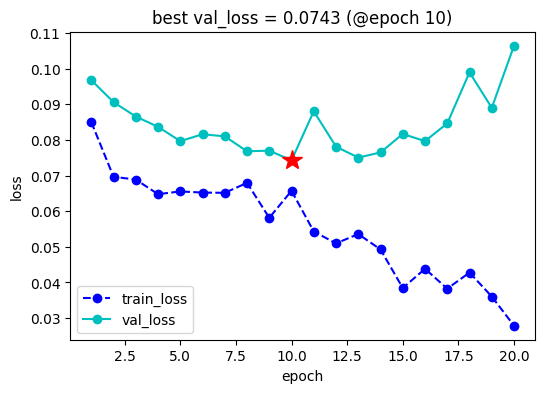

<<<<<< val_loss without improvement in 10 epoch,early stopping >>>>>>


,epoch,train_loss,lr,val_loss
0,1,0.085002,0.00006,0.096762
1,2,0.069643,0.00006,0.090588
2,3,0.068870,0.00006,0.086552
3,4,0.064769,0.00006,0.083662
4,5,0.065533,0.00006,0.079649
5,6,0.065219,0.00006,0.081573
6,7,0.065145,0.00006,0.080994
7,8,0.067934,0.00006,0.076796
8,9,0.058139,0.00006,0.076972
9,10,0.065717,0.00006,0.074264


In [67]:
# keras_model.load_ckpt(ckpt_path) #支持加载微调后的权重继续训练(断点续训)
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,patience=10,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path
               )


## 四，保存模型

为减少GPU压力，此处可重启kernel释放显存

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn
model_name_or_path ='../baichuan-13b'
ckpt_path = 'baichuan13b_waimai'
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    trust_remote_code=True
)
model_old = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map='auto'
)


[2023-07-19 23:21:49,363] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from peft import PeftModel

#可能需要5分钟左右
peft_model = PeftModel.from_pretrained(model_old, ckpt_path)
model_new = peft_model.merge_and_unload()



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...


In [4]:
from transformers.generation.utils import GenerationConfig
model_new.generation_config = GenerationConfig.from_pretrained(model_name_or_path)

In [5]:
from IPython.display import clear_output
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是什么？"})
response = model_new.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)

乔戈里峰。世界第二高峰———乔戈里峰西方登山者称其为k2峰，海拔高度是8611米，位于喀喇昆仑山脉的中巴边境上


In [6]:
save_path = 'baichuan-13b-waimai'

In [7]:
tokenizer.save_pretrained(save_path)
model_new.save_pretrained(save_path)

In [8]:
!cp ../baichuan-13b/*.py  baichuan-13b-waimai

## 五，使用模型

为减少GPU压力，此处可再次重启kernel释放显存。

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

model_name_or_path = 'baichuan-13b-waimai'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
from IPython.display import clear_output
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是什么？"})
response = model.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)

乔戈里峰。世界第二高峰———乔戈里峰
海拔高度：8610米
坐标纬度：35°49′15′′n,76°21′24′′e
地理位置：喀喇昆仑山脉中巴边境上


我们测试一下微调后的效果。

In [12]:
import pandas as pd 
import numpy as np 
import datasets 
from tqdm import tqdm 


In [15]:
prefix = """外卖评论文本分类任务:
下面是一些范例:

味道真不错 -> 好评
太辣了，吃不下都  -> 差评

请对下述评论进行分类。返回'好评'或者'差评'。
"""

def get_prompt(text):
    return prefix+text+' -> '


In [18]:
messages  = [{"role": "user", "content": get_prompt('味道不错，下次再来')}]
response = model.chat(tokenizer, messages)
print(response)


好评


In [19]:
messages = messages+[{"role": "assistant", "content": response}]
print(messages)

[{'role': 'user', 'content': "外卖评论文本分类任务:\n下面是一些范例:\n\n味道真不错 -> 好评\n太辣了，吃不下都  -> 差评\n\n请对下述评论进行分类。返回'好评'或者'差评'。\n味道不错，下次再来 -> "}, {'role': 'assistant', 'content': '好评'}]


In [20]:
def get_message(prompt,response):
    return [{"role": "user", "content": f'{prompt} -> '},
            {"role": "assistant", "content": response}]

In [21]:
messages.extend(get_message('太贵了','差评'))
messages.extend(get_message('非常快，味道好','好评'))
messages.extend(get_message('这么咸，真的是醉了','差评'))

In [22]:
def predict(text,temperature=0.01):
    model.generation_config.temperature=temperature
    response = model.chat(tokenizer, 
                          messages = messages+[{'role':'user','content':f'{text} -> '}])
    return response

In [23]:
predict('死鬼，怎么弄得这么好吃呢')

'好评'

In [25]:
#数据集加载
dftest = pd.read_parquet('../data/dftest.parquet')[['text','label','tag']]

In [26]:
dftest['pred'] = [predict(text) for text in tqdm(dftest['text'])]

100%|██████████| 2000/2000 [10:24<00:00,  3.20it/s]


In [27]:
print('acc = ',len(dftest.query('tag==pred'))/len(dftest))  

acc =  0.9015


微调后的acc为0.9015，相比微调前的0.8925，约提升1个百分点。

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)